# Bag-of-Words, TF-IDF, Co-occurrence Matrix

В этой части будут рассмотрены самые простые способы представления текста в виде вектора. Также на полученных признаках попробуем обучить несколько моделей машинного обучения и решить задачу классификации.

In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns

from tqdm import tqdm
from collections import Counter

from text_transformer import TextTransformer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split

from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

In [3]:
sns.set()
tqdm.pandas()

In [4]:
DATA_PATH = "data/train.csv"
STOP_WORDS = 'data/stop_words.txt'  # стоп-слова из предыдущей части
RANDOM_STATE = 42

Объявим функцию для заполнения результатов обучения, она понадобится чуть позже.

In [5]:
def fill_results(results, pipe, approach, model_name, X_train, y_train, X_val, y_val):
    predicts = pipe.predict(X_val)
    results.loc[f'{approach} + {model_name}', 'accuracy'] = accuracy_score(y_val, predicts) 
    results.loc[f'{approach} + {model_name}', 'precision'] = precision_score(y_val, predicts, average='weighted') 
    results.loc[f'{approach} + {model_name}', 'recall'] = recall_score(y_val, predicts, average='weighted') 
    results.loc[f'{approach} + {model_name}', 'f1-score'] = f1_score(y_val, predicts, average='weighted') 

    return results

Загрузим данные и обработаем их с помощью написанного ранее ```TextTransformer-а```:

In [6]:
with open(STOP_WORDS, encoding='utf-8') as file:
    stop_words = [w.strip() for w in file.readlines()]

In [7]:
df = pd.read_csv(DATA_PATH)
df.head()

,text,class
0,проблема: не открывается АКТ сверки по СБС № П...,1-46
1,В случае выбора неверного шаблона просьба указ...,1-70
2,Вопрос/информация Добрый день! В ЗНВ 300001962...,4-11
3,Вопрос/проблема: После выхода из отпуска с 01....,6-1
4,В УВХД необходимо снять резервирование с ЗНС *...,2-28


In [8]:
text_tf = TextTransformer(stop_words, stem=True)
df = text_tf.fit_transform(df)
df.head()

  0%|          | 0/15449 [00:00<?, ?it/s]

100%|██████████| 15449/15449 [01:56<00:00, 132.80it/s]


,text,class,doc,num_tokens,num_sentences,cleaned
0,проблема: не открывается АКТ сверки по СБС № П...,1-46,Doc(text='проблема: не открывается АКТ сверки ...,15,1,открыва акт сверк сбс пакет документ скан при...
1,В случае выбора неверного шаблона просьба указ...,1-70,Doc(text='В случае выбора неверного шаблона пр...,81,4,случа выбор неверн шаблон указа наименован кор...
2,Вопрос/информация Добрый день! В ЗНВ 300001962...,4-11,Doc(text='Вопрос/информация Добрый день! В ЗНВ...,39,2,информац знв граф сумм комисс необходим откор...
3,Вопрос/проблема: После выхода из отпуска с 01....,6-1,Doc(text='Вопрос/проблема: После выхода из отп...,90,6,посл выход отпуск .. мен увхд стат короч полаг...
4,В УВХД необходимо снять резервирование с ЗНС *...,2-28,Doc(text='В УВХД необходимо снять резервирован...,61,4,увхд необходим снят резервирован знс дава по...


Разобьем данные на обучающую и валидационную выборку и перейдем к рассмотрению алгоритмов векторизации.

In [9]:
X_train, X_val, y_train, y_val = train_test_split(df['cleaned'], df['class'], test_size=0.33, random_state=RANDOM_STATE)

### BoW

**Мешок слов (Bag-of-Words, BoW)** - это простая техника для получения векторного представления текста как коллекции слов, но при этом не учитывающая контекст, порядок слов и грамматические связи между словами.

Алгоритм построения BoW:
1. Создание словаря. В него входят все уникальные слова из корпуса текстов. Каждому слову присваивается индекс. Размерность словаря обозначим как $N$. Для улучшения качества словаря текст можно предварительно преобразовать: удалить стоп-слова и знаки пунктуации, лемматизировать или нормализовать любым другим способом.
2. Документ представляется в виде вектора размерностью $N$. Для каждого слова в документе считаем частоту его встречаемости и записываем по соответствующему индексу.

Пример построения мешка слов можно увидеть на рисунке:

![BoW example](images/bow_example.png)

Несмотря на простоту и понятность метода, у него есть некоторые ограничения:
- он не учитывает порядок слов в тексте, а только их наличие/отсутствие
- при работе с большим корпусом словарь становится огромным, а векторное представление текста - разреженным

Рассмотрим пример на практике. Для того чтобы преобразовать текст, нужно создать объект ```CountVectorizer``` и применить метод ```fit_transform()``` на обучающем наборе. 

In [10]:
bow = CountVectorizer()
X_train_bow = bow.fit_transform(X_train)

Посмотрим на размер словаря:

In [11]:
len(bow.vocabulary_)

7191

В атрибуте ```vocabulary_``` можно посмотреть частоту встречаемости слов по всему корпусу текстов. Это можно использовать для анализа словаря и определения стоп-слов.

In [12]:
bow.vocabulary_

{'оформлен': 3857,
 'командировк': 2217,
 'завест': 1458,
 'паспортн': 3933,
 'нажат': 2907,
 'выдава': 809,
 'пуст': 5045,
 'список': 5961,
 'доступн': 1310,
 'документ': 1251,
 'персональн': 4115,
 'информац': 1903,
 'ран': 5155,
 'оформля': 3860,
 'срочн': 6009,
 'июн': 2001,
 'удал': 6484,
 'знс': 1722,
 'закр': 1528,
 'ве': 502,
 'знз': 1711,
 'тепер': 6260,
 'пыта': 5066,
 'отозва': 3754,
 'согласован': 5794,
 'программ': 4878,
 'писа': 4147,
 'созда': 5827,
 'отз': 3703,
 'невозможн': 3052,
 'котор': 2369,
 'коллег': 2202,
 'присво': 4793,
 'подписан': 4291,
 'накладн': 2933,
 'поч': 4570,
 'эд': 7081,
 'приня': 4777,
 'бухгалтер': 426,
 'необходим': 3132,
 'получ': 4428,
 'инициатор': 1860,
 'списан': 5958,
 'помоч': 4454,
 'систем': 5627,
 'увхд': 6475,
 'исполнен': 1945,
 'заявк': 1658,
 'втор': 778,
 'шаг': 7019,
 'выда': 808,
 'ошибк': 3886,
 'бюджет': 445,
 'прийт': 4730,
 'сообщен': 5852,
 'направлен': 2973,
 'запрос': 1599,
 'нажа': 2906,
 'сохранен': 5913,
 'проект': 49

BoW можно использовать не только для отдельных слов, но и для n-грамм. Создадим новый объект ```CountVectorizer```, который будет уметь работать как с отдельными словами, так и с биграммами.

In [13]:
bw_ngrams = CountVectorizer(ngram_range=(1, 2))
X_train_bow_ngrams = bw_ngrams.fit_transform(X_train)

За счет добавления биграмм значительно увеличился словарь:

In [14]:
bw_ngrams.get_feature_names_out()

array(['_операц', '_операц наличн', '_отраж', ..., 'ящик', 'ящик никак',
       'ящик темпокасс'], dtype=object)

In [15]:
len(bw_ngrams.vocabulary_)

89916

In [16]:
bw_ngrams.vocabulary_

{'оформлен': 46713,
 'командировк': 28530,
 'завест': 17395,
 'паспортн': 48196,
 'нажат': 34787,
 'выдава': 9103,
 'пуст': 62298,
 'список': 75185,
 'доступн': 15944,
 'документ': 14639,
 'персональн': 49783,
 'информац': 25093,
 'ран': 63779,
 'оформля': 46783,
 'срочн': 75998,
 'июн': 26534,
 'оформлен командировк': 46745,
 'командировк завест': 28636,
 'завест паспортн': 17442,
 'паспортн нажат': 48212,
 'нажат выдава': 34789,
 'выдава пуст': 9153,
 'пуст список': 62327,
 'список доступн': 75210,
 'доступн документ': 15955,
 'документ персональн': 14871,
 'персональн информац': 49791,
 'информац паспортн': 25224,
 'паспортн завест': 48205,
 'завест ран': 17453,
 'ран командировк': 63833,
 'командировк оформля': 28787,
 'оформля срочн': 46818,
 'срочн командировк': 76047,
 'командировк июн': 28671,
 'удал': 82784,
 'знс': 22147,
 'закр': 18299,
 'ве': 4658,
 'знз': 21295,
 'тепер': 79678,
 'пыта': 62523,
 'отозва': 45036,
 'согласован': 71648,
 'программ': 60388,
 'писа': 49933,
 'с

#### Обучение моделей 

Теперь, когда мы научились выделять признаки из текста с помощью BoW, попробуем обучить несколько моделей для решения задачи классификации текстов. Обработку текстов можно организовать с помощью sklearn-конвейера. В результате на вход можно будет подавать исходный текст, а на выходе получать класс, к которому он принадлежит. 

Для ускорения работы будем пользоваться заранее очищенным и лемматизированным обучающим набором, однако для полного преобразования текста в продакшн-модели ```TextTransformer``` обязательно должен быть включен в конвейер. 

Создадим датафрейм, в который будем записывать метрики работы модели.

In [17]:
results_bow = pd.DataFrame(columns=['accuracy', 'precision', 'recall', 'f1-score'])

In [18]:
pipe = Pipeline([
    # ('text_preprocessor', TextTransformer(stop_words)),
    ('preprocessor', CountVectorizer()),  # мешок слов
    ('model', LinearSVC(random_state=RANDOM_STATE, max_iter=1000))   # метод опорных векторов
])
pipe.fit(X_train, y_train)
results_bow = fill_results(results_bow, pipe, 'BoW', 'SVM', X_train, y_train, X_val, y_val)

results_bow

,accuracy,precision,recall,f1-score
BoW + SVM,0.65405,0.647112,0.65405,0.647059


In [19]:
pipe = Pipeline([
    # ('text_preprocessor', TextTransformer(stop_words)),
    ('preprocessor', CountVectorizer(ngram_range=(1, 2))),   # мешок слов с n-граммами
    ('model', LinearSVC(random_state=RANDOM_STATE, max_iter=1000))  # метод опорных векторов
])
pipe.fit(X_train, y_train)
results_bow = fill_results(results_bow, pipe, 'BoW ngrams', 'SVM', X_train, y_train, X_val, y_val)

results_bow

,accuracy,precision,recall,f1-score
BoW + SVM,0.65405,0.647112,0.65405,0.647059
BoW ngrams + SVM,0.69445,0.688863,0.69445,0.686226


In [20]:
pipe = Pipeline([
    # ('text_preprocessor', TextTransformer(stop_words)),
    ('preprocessor', CountVectorizer()),  # мешок слов
    ('model', LogisticRegression(random_state=RANDOM_STATE))  # логистическая регрессия
])
pipe.fit(X_train, y_train)
results_bow = fill_results(results_bow, pipe, 'BoW', 'LogReg', X_train, y_train, X_val, y_val)

results_bow

,accuracy,precision,recall,f1-score
BoW + SVM,0.65405,0.647112,0.65405,0.647059
BoW ngrams + SVM,0.69445,0.688863,0.69445,0.686226
BoW + LogReg,0.689351,0.692031,0.689351,0.683211


In [21]:
pipe = Pipeline([
    # ('text_preprocessor', TextTransformer(stop_words)),
    ('preprocessor', CountVectorizer(ngram_range=(1, 2))),  # мешок слов с n-граммами
    ('model', LogisticRegression(random_state=RANDOM_STATE))  # логистическая регрессия
])
pipe.fit(X_train, y_train)
results_bow = fill_results(results_bow, pipe, 'BoW ngrams', 'LogReg', X_train, y_train, X_val, y_val)

results_bow

,accuracy,precision,recall,f1-score
BoW + SVM,0.65405,0.647112,0.65405,0.647059
BoW ngrams + SVM,0.69445,0.688863,0.69445,0.686226
BoW + LogReg,0.689351,0.692031,0.689351,0.683211
BoW ngrams + LogReg,0.700137,0.708034,0.700137,0.692465


In [22]:
pipe = Pipeline([
    # ('text_preprocessor', TextTransformer(stop_words)),
    ('preprocessor', CountVectorizer()),  # мешок слов
    ('model', RandomForestClassifier(random_state=RANDOM_STATE))  # случайный лес
])
pipe.fit(X_train, y_train)
results_bow = fill_results(results_bow, pipe, 'BoW', 'RF', X_train, y_train, X_val, y_val)

results_bow

,accuracy,precision,recall,f1-score
BoW + SVM,0.65405,0.647112,0.65405,0.647059
BoW ngrams + SVM,0.69445,0.688863,0.69445,0.686226
BoW + LogReg,0.689351,0.692031,0.689351,0.683211
BoW ngrams + LogReg,0.700137,0.708034,0.700137,0.692465
BoW + RF,0.666797,0.682859,0.666797,0.647046


In [23]:
pipe = Pipeline([
    # ('text_preprocessor', TextTransformer(stop_words)),
    ('preprocessor', CountVectorizer(ngram_range=(1, 2))),  # мешок слов с n-граммами
    ('model', RandomForestClassifier(random_state=RANDOM_STATE))  # случайный лес
])
pipe.fit(X_train, y_train)
results_bow = fill_results(results_bow, pipe, 'BoW ngrams', 'RF', X_train, y_train, X_val, y_val)

results_bow

,accuracy,precision,recall,f1-score
BoW + SVM,0.65405,0.647112,0.65405,0.647059
BoW ngrams + SVM,0.69445,0.688863,0.69445,0.686226
BoW + LogReg,0.689351,0.692031,0.689351,0.683211
BoW ngrams + LogReg,0.700137,0.708034,0.700137,0.692465
BoW + RF,0.666797,0.682859,0.666797,0.647046
BoW ngrams + RF,0.65758,0.684856,0.65758,0.63664


### TF-IDF

Этот подход основан на следующей идее. Если слова часто встречаются, то они малоинформативные, в то время как редкие слова информативны, но на них сложно опираться. Для того чтобы модель машинного обучения работала наиболее эффективно, требуется найти баланс между частотностью и информативностью. Это можно сделать, опираясь на следующие предположения:
- Чем чаще слово встречается в документе, тем более оно характерно для этого документа.
- Чем реже встречается это слово в наборе (корпусе) документов, тем более оно информативно.

На основании этих предположений введем следующие понятия. 

**TF (Term Frequency)** – это отношение количества употреблений слова $w$ в документе $d$ к общему числу слов в документе $d$. Оно позволяет определить значимость слова в документе (чем выше TF, тем больше значимость слова в этом документе).

$TF = \frac {(frequency(w, d))} {(length(d))}$

**IDF (Inverse Document Frequency)** – это логарифм отношения размера всей коллекции $C$ (в документах) к количеству документов в коллекции $C$, в которых встречается слово $w$. Оно позволяет определить специфичность слова и при этом снизить значимость слов, часто встречающихся в корпусе. 

$IDF = log(\frac {⁡length(C)} {count(w, C)})$

Итоговый вес слова можно определить следующим образом:

$TFIDF(w, d, C) = TF(w, d) \cdot IDF(w, C)$

Другими словами, TF-IDF считает слово значимым для данного документа, если оно часто встречается в конкретном документе и редко встречается в корпусе документов.
Это преобразование позволяет установить пороги: если слово встречается слишком часто, то TF-IDF будет низким, и часть токенов можно будет отбросить. Если слово встречается слишком редко, то оно может казаться опечаткой, но при этом его значимость будет высокой. Таким образом, появляется возможность удалить их из словаря.

Рассмотрим на практике реализацию от sklearn. Для того чтобы преобразовать текст с помощью описанных выше формул, нужно создать объект ```TfidfVectorizer``` и применить метод ```fit_transform()``` на обучающем наборе. 


In [24]:
tfidf = TfidfVectorizer()
X_train_tfidf = tfidf.fit_transform(X_train)

Посмотрим на размер словаря и на слова, которые в него попали. Видим, что словарь в атрибуте ```vocabulary_``` такой же, как и в примере с BoW. Действительно, от мешка слов можно легко перейти к представлению TF-IDF, рассчитав параметры по формулам.

In [25]:
len(tfidf.vocabulary_)

7191

В отличие от примера с BoW, у объекта ```TfidfVectorizer``` появляется новый атрибут ```idf_```. В нем можно посмотреть значимость слова в словаре. Эту информацию можно использовать для поиска стоп-слов на этапе анализа данных. Построим график наиболее важных 30 слов.

In [26]:
tfidf_features = pd.DataFrame({
    'words': tfidf.get_feature_names_out(),
    'idf': tfidf.idf_
}).sort_values(by='idf', ascending=False)
tfidf_features.tail()

,words,idf
1722,знс,2.893680
5827,созда,2.831471
1230,договор,2.768366
3886,ошибк,2.652472
3132,необходим,2.593243


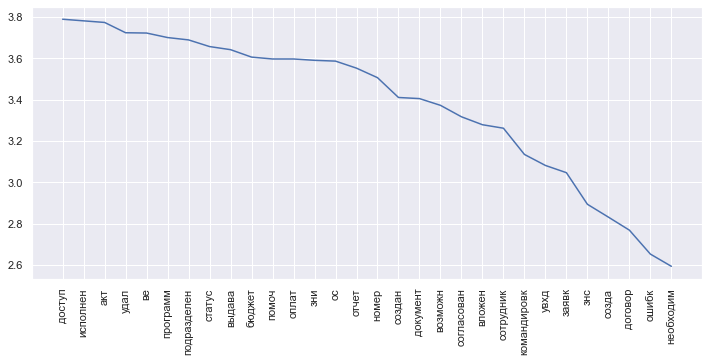

In [27]:
fig = plt.figure(figsize=(12, 5));
plt.plot(tfidf_features.tail(30)['words'].values, tfidf_features.tail(30)['idf'].values);
plt.xticks(rotation=90);

Как и BoW, TF-IDF можно использовать для n-грамм, а не только для отдельных слов. Создадим новый объект ```TfidfVectorizer```, который будет уметь работать как с отдельными словами, так и с комбинациями слов. Для бысрого обучения моделей ограничимся биграммами, однако использование триграмм и n-грамм может повысить качество моделей.

In [28]:
tfidf_ngrams = TfidfVectorizer(ngram_range=(1, 2))
X_train_tfidf_ngrams = tfidf_ngrams.fit_transform(X_train)

Выведем названия слов и сочетаний слов, вошедших в словарь. Видим, что помимо отдельных слов появились биграммы:

In [29]:
tfidf_ngrams.get_feature_names_out()

array(['_операц', '_операц наличн', '_отраж', ..., 'ящик', 'ящик никак',
       'ящик темпокасс'], dtype=object)

Также за счет добавления биграмм значительно увеличился словарь:

In [30]:
len(tfidf_ngrams.vocabulary_)

89916

Выведем 5 самых часто встречающихся слов в словаре, опираясь на значения из атрибута ```idf_```:

In [31]:
tfidf_ngrams_features = pd.DataFrame({
    'words': tfidf_ngrams.get_feature_names_out(),
    'idf': tfidf_ngrams.idf_
}).sort_values(by='idf', ascending=False)
tfidf_ngrams_features.head()

,words,idf
0,_операц,9.551691
55544,порядок полност,9.551691
55542,порядок подписан,9.551691
55541,порядок перемещен,9.551691
55539,порядок открыва,9.551691


#### Обучение моделей 

Обучим модели на признаках, полученных с помощью ```TfidfVectorizer```.

In [32]:
results_tfidf = pd.DataFrame(columns=['accuracy', 'precision', 'recall', 'f1-score'])

In [33]:
pipe = Pipeline([
    # ('text_preprocessor', TextTransformer(stop_words)),
    ('preprocessor', TfidfVectorizer()),  # tf-idf
    ('model', LinearSVC(random_state=RANDOM_STATE, max_iter=1000))  # метод опорных векторов
])
pipe.fit(X_train, y_train)
results_tfidf = fill_results(results_tfidf, pipe, 'TF-IDF', 'SVM', X_train, y_train, X_val, y_val)

results_tfidf

,accuracy,precision,recall,f1-score
TF-IDF + SVM,0.695627,0.688648,0.695627,0.685411


In [34]:
pipe = Pipeline([
    # ('text_preprocessor', TextTransformer(stop_words)),
    ('preprocessor', TfidfVectorizer(ngram_range=(1, 2))),  # tf-idf с n-граммами
    ('model', LinearSVC(random_state=RANDOM_STATE, max_iter=1000))  # метод опорных векторов
])
pipe.fit(X_train, y_train)
results_tfidf = fill_results(results_tfidf, pipe, 'TF-IDF ngrams', 'SVM', X_train, y_train, X_val, y_val)

results_tfidf

,accuracy,precision,recall,f1-score
TF-IDF + SVM,0.695627,0.688648,0.695627,0.685411
TF-IDF ngrams + SVM,0.71112,0.707626,0.71112,0.697734


In [35]:
pipe = Pipeline([
    # ('text_preprocessor', TextTransformer(stop_words)),
    ('preprocessor', TfidfVectorizer()),  # tf-idf
    ('model', LogisticRegression(random_state=RANDOM_STATE))  # логистическая регрессия
])
pipe.fit(X_train, y_train)
results_tfidf = fill_results(results_tfidf, pipe, 'TF-IDF', 'LogReg', X_train, y_train, X_val, y_val)

results_tfidf

,accuracy,precision,recall,f1-score
TF-IDF + SVM,0.695627,0.688648,0.695627,0.685411
TF-IDF ngrams + SVM,0.71112,0.707626,0.71112,0.697734
TF-IDF + LogReg,0.657972,0.685572,0.657972,0.644266


In [36]:
pipe = Pipeline([
    # ('text_preprocessor', TextTransformer(stop_words)),
    ('preprocessor', TfidfVectorizer(ngram_range=(1, 2))),   # tf-idf с n-граммами
    ('model', LogisticRegression(random_state=RANDOM_STATE))  # логистическая регрессия
])
pipe.fit(X_train, y_train)
results_tfidf = fill_results(results_tfidf, pipe, 'TF-IDF ngrams', 'LogReg', X_train, y_train, X_val, y_val)

results_tfidf

,accuracy,precision,recall,f1-score
TF-IDF + SVM,0.695627,0.688648,0.695627,0.685411
TF-IDF ngrams + SVM,0.71112,0.707626,0.71112,0.697734
TF-IDF + LogReg,0.657972,0.685572,0.657972,0.644266
TF-IDF ngrams + LogReg,0.618357,0.687118,0.618357,0.595995


In [37]:
pipe = Pipeline([
    # ('text_preprocessor', TextTransformer(stop_words)),
    ('preprocessor', TfidfVectorizer()),  # tf-idf
    ('model', RandomForestClassifier(random_state=RANDOM_STATE))  # случайный лес
])
pipe.fit(X_train, y_train)
results_tfidf = fill_results(results_tfidf, pipe, 'TF-IDF', 'RF', X_train, y_train, X_val, y_val)

results_tfidf

,accuracy,precision,recall,f1-score
TF-IDF + SVM,0.695627,0.688648,0.695627,0.685411
TF-IDF ngrams + SVM,0.71112,0.707626,0.71112,0.697734
TF-IDF + LogReg,0.657972,0.685572,0.657972,0.644266
TF-IDF ngrams + LogReg,0.618357,0.687118,0.618357,0.595995
TF-IDF + RF,0.670328,0.689606,0.670328,0.650845


In [38]:
pipe = Pipeline([
    # ('text_preprocessor', TextTransformer(stop_words)),
    ('preprocessor', TfidfVectorizer(ngram_range=(1, 2))),   # tf-idf с n-граммами
    ('model', RandomForestClassifier(random_state=RANDOM_STATE))  # случайный лес
])
pipe.fit(X_train, y_train)
results_tfidf = fill_results(results_tfidf, pipe, 'TF-IDF ngrams', 'RF', X_train, y_train, X_val, y_val)

results_tfidf

,accuracy,precision,recall,f1-score
TF-IDF + SVM,0.695627,0.688648,0.695627,0.685411
TF-IDF ngrams + SVM,0.71112,0.707626,0.71112,0.697734
TF-IDF + LogReg,0.657972,0.685572,0.657972,0.644266
TF-IDF ngrams + LogReg,0.618357,0.687118,0.618357,0.595995
TF-IDF + RF,0.670328,0.689606,0.670328,0.650845
TF-IDF ngrams + RF,0.660129,0.687001,0.660129,0.638875


### Co-occurrence matrix

In [31]:
co_occurrence = CountVectorizer(ngram_range=(2, 2))
X_train_cooccurrence = co_occurrence.fit_transform(X_train)

In [35]:
co_occurrence_matrix = np.sum(X_train_cooccurrence.todense(), axis=0)
list(zip(co_occurrence.get_feature_names(), np.array(co_occurrence_matrix)[0].tolist()))

[('_операции наличный', 1),
 ('_отражена бухг', 1),
 ('аа видеть', 1),
 ('аа вм', 1),
 ('аа возможность', 1),
 ('аа дважды', 1),
 ('аа привязка', 1),
 ('аа связь', 1),
 ('аба упр', 2),
 ('абакан наименование', 1),
 ('абакан пушкин', 2),
 ('абакан управление', 1),
 ('абакан цель', 1),
 ('абаканский госб', 1),
 ('абаканский отделение', 1),
 ('абдрашитов вадимович', 1),
 ('абдуганиевич дата', 1),
 ('абинякина программа', 1),
 ('або управленя', 1),
 ('абрикович таб', 1),
 ('абс гамма', 1),
 ('абсолютно новый', 1),
 ('абсолютно отозвать', 1),
 ('абсолютно пустой', 1),
 ('абсолютно уверенный', 1),
 ('абсолютный совпадение', 1),
 ('абэда дата', 1),
 ('абэда документ', 2),
 ('ава аа', 1),
 ('ава отчет', 4),
 ('ававнсовый счет', 1),
 ('аванс аванс', 2),
 ('аванс акт', 3),
 ('аванс аналогичный', 1),
 ('аванс брать', 1),
 ('аванс видеть', 1),
 ('аванс вкладка', 1),
 ('аванс возникать', 1),
 ('аванс вручную', 1),
 ('аванс выбираться', 1),
 ('аванс выдавать', 4),
 ('аванс выплатить', 1),
 ('аванс в